In [1]:
!pip install boto3

In [2]:
# Cell 1: Install and Import Required Packages
import sys
import subprocess

# Install required packages
subprocess.check_call([sys.executable, "-m", "pip", "install", "boto3", "pandas", "matplotlib", "seaborn", "scikit-learn", "imbalanced-learn", "tld", "scipy"])

# Import packages
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import numpy as np
import math
import re
import os
import json
import pickle
import warnings
import string
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
from scipy import stats
import tld
from sklearn.calibration import CalibratedClassifierCV


# Import sklearn components
try:
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
    from sklearn.utils import shuffle
except ImportError as e:
    print(f"Warning: Error importing from sklearn: {e}")
    print("Some functionalities may not work correctly.")
    
    # Define basic shuffle function as fallback
    def shuffle(X, y, random_state=None):
        if random_state is not None:
            np.random.seed(random_state)
        p = np.random.permutation(len(X))
        return X[p], y[p]

        
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached tld-0.13-py2.py3-none-any.whl.metadata (9.4 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached tld-0.13-py2.py3-none-any.whl (263 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)


In [3]:
# Create a Boto3 S3 client
s3 = boto3.client('s3')

# Define your bucket name
bucket_name = 'amazon-sagemaker-715841371012-us-east-2-c8144fb3a945'

# Specify the file names stored in S3
training_data = 'training.csv'
validating_data = 'validating.csv'

# Download the files from S3
s3.download_file(bucket_name, training_data, 'training.csv')
s3.download_file(bucket_name, validating_data, 'validating.csv')

In [4]:
# Read the data from the downloaded CSVs from S3
training_data = pd.read_csv('training.csv', names=['label', 'query'])
validating_data = pd.read_csv('validating.csv', names=['label', 'query'])

# Check the first few records to ensure the data is correct
print(training_data.head())
print(validating_data.head())

   label                                              query
0      1                         q+Z8AnwaBA.hidemyself.org.
1      1                         q+Z8A3wbBA.hidemyself.org.
2      1                         q+Z8BHwcBA.hidemyself.org.
3      1                         q+Z8BXwdBA.hidemyself.org.
4      1  q+Z8BnweCORdAGL4+W7DB5xH1cUwcwM1gejAQoJF8hbs2J...
   label                                              query
0      1                         q+aJ04nrBA.hidemyself.org.
1      1                         q+aJ1InsBA.hidemyself.org.
2      1                         q+aJ1YntBA.hidemyself.org.
3      1  q+aJ1onuCDT2aA0NEkzbTnzRPgWJE7aYtQhjcSmnj74ufU...
4      1  q+aJ14nvCHKAcMCkiIhCb3eY1s8cgWt39jSJuK4299f/S5...


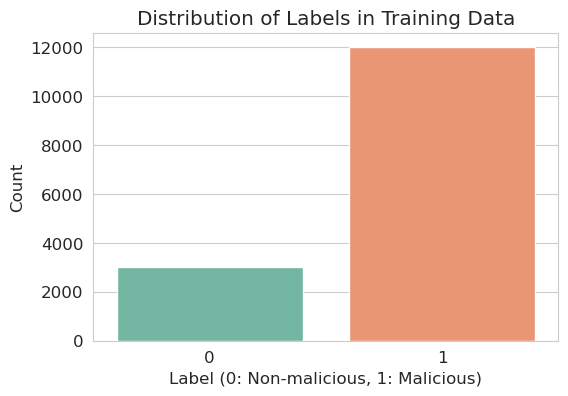

In [5]:
# Visualizing the distribution of labels (0 and 1)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=training_data, palette="Set2")
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label (0: Non-malicious, 1: Malicious)')
plt.ylabel('Count')
plt.show()


In [6]:
#Calculate Entropy and Length for Domain Names
# Calculate entropy for domain name
def calculate_entropy(text):
    if not text: 
        return 0 
    entropy = 0
    for x in range(256): 
        p_x = float(text.count(chr(x)))/len(text) 
        if p_x > 0: 
            entropy += - p_x * math.log(p_x, 2) 
    return entropy

# Calculate length of the domain name
def calculate_length(text):
    if not text:
        return 0
    return len(text)

# For training data
entropy_train_vals = []
length_train_vals = []

for query in training_data['query']:
    entropy_train_vals.append(calculate_entropy(query))
    length_train_vals.append(calculate_length(query))

training_data['entropy'] = entropy_train_vals
training_data['length'] = length_train_vals

# For validating data
entropy_test_vals = []
length_test_vals = []

for query in validating_data['query']:
    entropy_test_vals.append(calculate_entropy(query))
    length_test_vals.append(calculate_length(query))

validating_data['entropy'] = entropy_test_vals
validating_data['length'] = length_test_vals

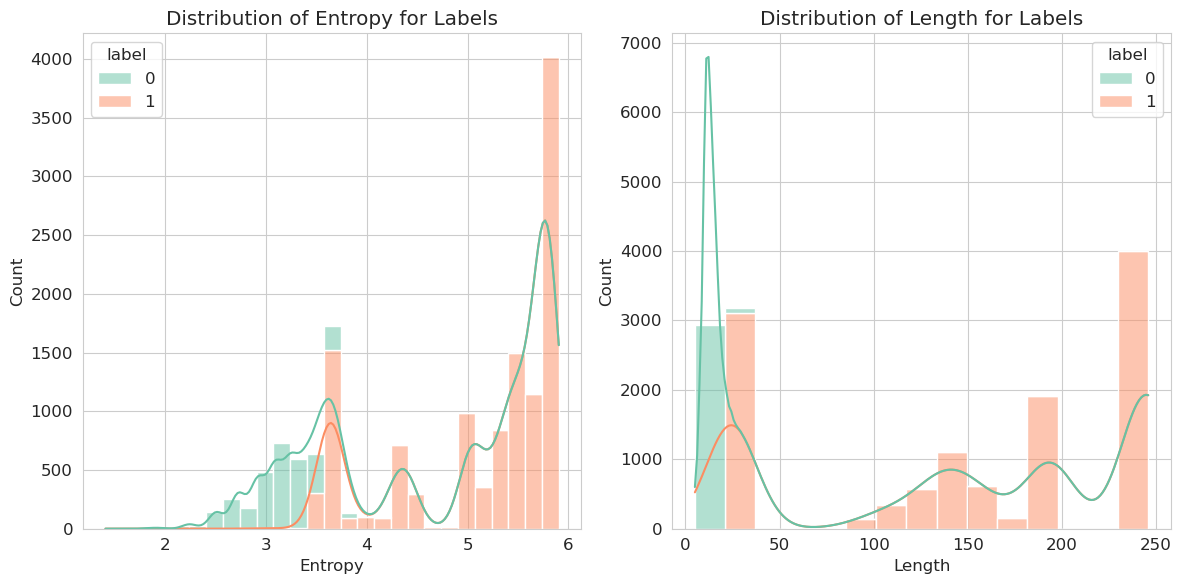

In [7]:
# Plotting the distribution of 'entropy' and 'length' for both classes
plt.figure(figsize=(12, 6))

# Subplot for entropy
plt.subplot(1, 2, 1)
sns.histplot(data=training_data, x='entropy', hue='label', multiple="stack", kde=True, palette="Set2")
plt.title('Distribution of Entropy for Labels')
plt.xlabel('Entropy')

# Subplot for length
plt.subplot(1, 2, 2)
sns.histplot(data=training_data, x='length', hue='label', multiple="stack", kde=True, palette="Set2")
plt.title('Distribution of Length for Labels')
plt.xlabel('Length')

plt.tight_layout()
plt.show()


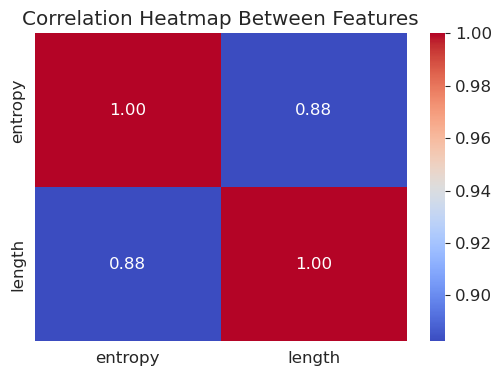

In [8]:
# Correlation matrix
corr = training_data[['entropy', 'length']].corr()

# Plotting the heatmap - how much they correlate
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Between Features')
plt.show()


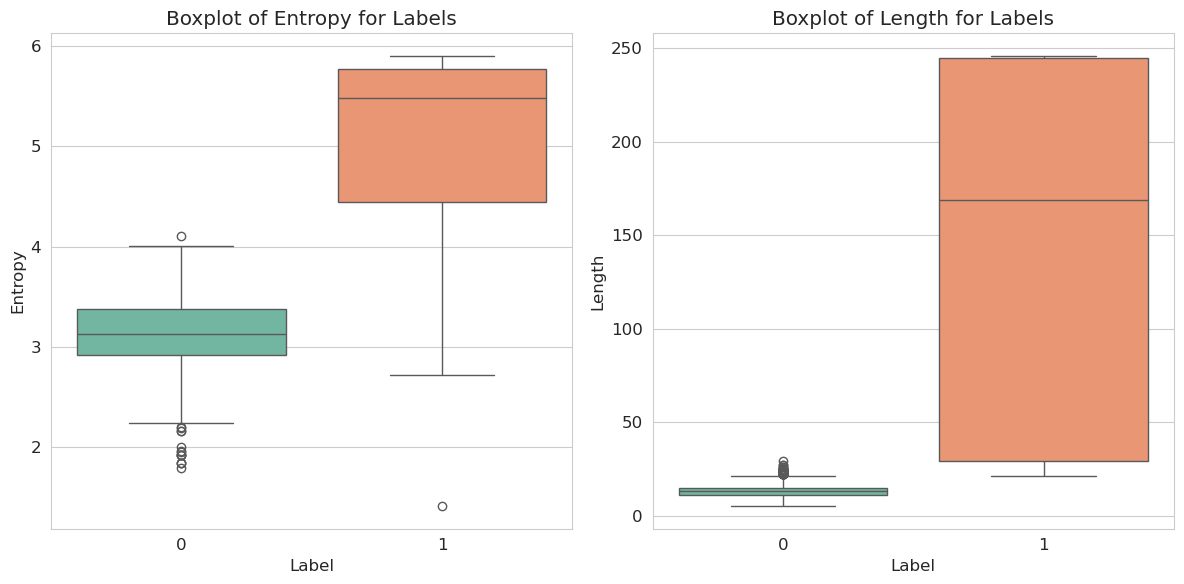

In [9]:
# Boxplot for Entropy and Length by Label
plt.figure(figsize=(12, 6))

# Entropy Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='entropy', data=training_data, palette="Set2")
plt.title('Boxplot of Entropy for Labels')
plt.xlabel('Label')
plt.ylabel('Entropy')

# Length Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='length', data=training_data, palette="Set2")
plt.title('Boxplot of Length for Labels')
plt.xlabel('Label')
plt.ylabel('Length')

plt.tight_layout()
plt.show()


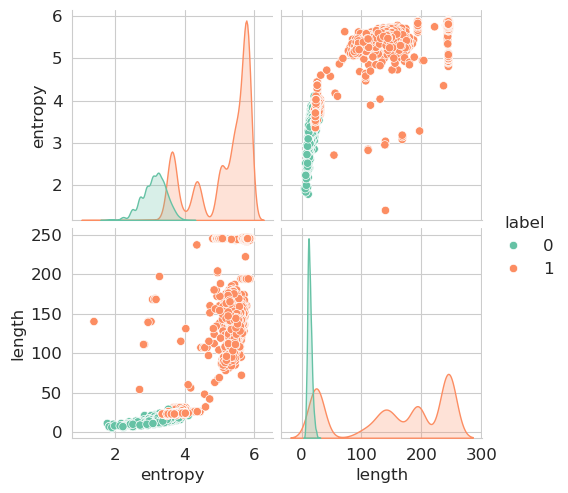

In [10]:
# Pairplot of the features (Entropy and Length)
sns.pairplot(training_data[['entropy', 'length', 'label']], hue="label", palette="Set2")
plt.show()


In [11]:
#Prepare the Data for Model Training
X_train = training_data[['entropy', 'length']]  # Features
Y_train = training_data['label']   # Labels (0 or 1)

# Reshape if needed (though it's not strictly required here as you're already dealing with 2 columns)
X_train = X_train.values
Y_train = Y_train.values.reshape(-1, 1).ravel()

# Check shapes
print(X_train.shape, Y_train.shape)


(15000, 2) (15000,)


In [12]:
#Train the Logistic Regression Model
# Initialize the Logistic Regression model
lgs_model = LogisticRegression(max_iter=500)

# Training the model with cross-validation
accuracy = cross_val_score(lgs_model, X_train, Y_train, cv=5, scoring='accuracy')
precision = cross_val_score(lgs_model, X_train, Y_train, cv=5, scoring='precision')
recall = cross_val_score(lgs_model, X_train, Y_train, cv=5, scoring='recall')
f1 = cross_val_score(lgs_model, X_train, Y_train, cv=5, scoring='f1')
roc_auc = cross_val_score(lgs_model, X_train, Y_train, cv=5, scoring='roc_auc')

# Print the evaluation metrics
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1", f1)
print("ROC AUC", roc_auc)


Accuracy [0.99666667 0.99766667 0.993      0.99333333 0.99433333]
Precision [0.99585062 0.99709182 0.99213902 0.99173554 0.99296649]
Recall [1.         1.         0.99916667 1.         1.        ]
F1 [0.997921   0.99854379 0.99564044 0.99585062 0.99647083]
ROC AUC [0.99939444 1.         0.99979549 0.99750382 0.9912375 ]


In [13]:
#Fit the Model on the Training Data
# Shuffle the training data before fitting
X_train, Y_train = shuffle(X_train, Y_train)

# Fit the model
lgs_model.fit(X_train, Y_train)


LogisticRegression(max_iter=500)

In [14]:
#Evaluate on Validation Data
# Prepare validation data
X_test = validating_data[['entropy', 'length']]  # Features
Y_test = validating_data['label']  # True labels

# Reshape validation data (if needed)
X_test = X_test.values
Y_test = Y_test.values.reshape(-1, 1).ravel()

# Predict using the trained model
Y_pred = lgs_model.predict(X_test)

# Print evaluation metrics
print("Accuracy", accuracy_score(Y_test, Y_pred))
print("Precision", precision_score(Y_test, Y_pred))
print("Recall", recall_score(Y_test, Y_pred))
print("F1", f1_score(Y_test, Y_pred))
print("ROC AUC", roc_auc_score(Y_test, Y_pred))

# Print classification report
print(classification_report(Y_test, Y_pred))


Accuracy 0.9926
Precision 0.9908347783007183
Recall 1.0
F1 0.9953962921488118
ROC AUC 0.9814999999999999
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1000
           1       0.99      1.00      1.00      4000

    accuracy                           0.99      5000
   macro avg       1.00      0.98      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [15]:
#Export the Trained Model
import pickle

# Save the trained model to a file
pickle.dump(lgs_model, open('DNS_tunnel_domains_classificator.pkl', 'wb'))


In [16]:
loaded_model = pickle.load(open('DNS_tunnel_domains_classificator.pkl', 'rb'))

In [17]:

#  Define function to test model on PCAP data
#################################################################################
# New section: Testing the model on real-world DNS traffic data
#################################################################################

print("\n\n========= Testing Model on Real Packet Capture Data =========\n")

def test_model_on_pcap_data(pcap_csv_file, model):
    """
    Test the trained model on real DNS traffic data from a PCAP CSV.
    
    Args:
        pcap_csv_file: Path to the CSV file containing packet capture data
        model: Trained model for DNS tunneling detection
    
    Returns:
        DataFrame with the detected tunneling attempts
    """
    print(f"Loading packet capture data from {pcap_csv_file}...")
    
    try:
        # Read the packet capture CSV file
        try:
            # First try with comma delimiter which is standard
            pcap_data = pd.read_csv(pcap_csv_file)
        except:
            # If that fails, try to automatically detect the delimiter
            pcap_data = pd.read_csv(pcap_csv_file, delimiter=None, engine='python')
            
        print(f"Loaded {len(pcap_data)} packets from capture file.")
        
        # Display sample of the data
        print("\nSample of packet capture data:")
        print(pcap_data.head())
        
        # Extract the columns - we need to handle different pcap CSV formats
        if 'Info' in pcap_data.columns:
            info_col = 'Info'
        elif 'info' in pcap_data.columns:
            info_col = 'info'
        else:
            # Try to find a column that might contain DNS info
            for col in pcap_data.columns:
                if pcap_data[col].dtype == 'object' and pcap_data[col].str.contains('DNS', case=False, na=False).any():
                    info_col = col
                    break
            else:
                raise ValueError("Could not find a column containing DNS information")
        
        print(f"\nUsing '{info_col}' column for DNS query extraction")
        
        # Filter for DNS packets - adjusted for our specific format
        dns_filter = pcap_data[info_col].str.contains('DNS|dns|dnscat|query|Standard query', case=False, regex=True, na=False)
        dns_packets = pcap_data[dns_filter]
        
        # Also check Protocol column if it exists
        if len(dns_packets) == 0 and 'Protocol' in pcap_data.columns:
            dns_filter = pcap_data['Protocol'].str.contains('DNS', case=False, na=False)
            dns_packets = pcap_data[dns_filter]
        
        print(f"Found {len(dns_packets)} DNS packets in the capture")
        
        if len(dns_packets) == 0:
            # Let's print a sample of info fields to help understand the format
            print("\nSample of Info field values to check format:")
            sample_infos = pcap_data[info_col].dropna().unique()[:10]
            for info in sample_infos:
                print(f"- {info}")
            
            # For the TXT dnscat packets specifically that might not be caught by DNS filter
            dnscat_filter = pcap_data[info_col].str.contains('dnscat', case=False, na=False)
            dnscat_packets = pcap_data[dnscat_filter]
            
            if len(dnscat_packets) > 0:
                print(f"\nFound {len(dnscat_packets)} dnscat packets that may not be labeled as DNS")
                dns_packets = dnscat_packets
            else:
                # Try direct extraction regardless of DNS label
                dns_packets = pcap_data  # Try with all packets
                print("\nNo DNS-labeled packets found. Attempting to extract domains from all packets.")
                
        # Extract domain names from DNS queries using regex patterns tuned to our specific format
        # Based on analysis of the CSV file, common format is: "Standard query 0xXXXX TYPE dnscat.HEXSTRING"
        domain_patterns = [
            # Standard DNS query pattern 
            re.compile(r'Standard query.*?(?:A|AAAA|TXT|MX|CNAME)\s+([a-zA-Z0-9.-]+\.[a-zA-Z0-9.-]+)'),
            # Specific dnscat pattern seen in our data
            re.compile(r'(dnscat\.[a-zA-Z0-9]+)'),
            # DNS response pattern
            re.compile(r'Standard query response.*?(?:A|AAAA|TXT|MX|CNAME)\s+([a-zA-Z0-9.-]+\.[a-zA-Z0-9.-]+)'),
            # Broader domain pattern as fallback
            re.compile(r'\b([a-zA-Z0-9][-a-zA-Z0-9.]{0,61}[a-zA-Z0-9]\.[a-zA-Z]{2,})\b')
        ]
        
        # Function to extract domain from DNS info using multiple patterns
        def extract_domain(info):
            if not isinstance(info, str):
                return None
                
            try:
                # Try each pattern in order
                for pattern in domain_patterns:
                    match = pattern.search(info)
                    if match:
                        return match.group(1)
                
                # Look for dnscat domains specifically with hex patterns
                for word in info.split():
                    if word.startswith('dnscat.') and len(word) > 10:
                        return word
                
                return None
            except Exception as e:
                print(f"Error processing DNS info: {e}")
                return None
        
        # Create a list of domains from the DNS queries
        dns_records = []
        
        for _, packet in dns_packets.iterrows():
            domain = extract_domain(packet[info_col])
            if domain:
                record = {
                    'domain': domain,
                    'info': packet[info_col]
                }
                
                # Add timestamp if available
                if 'Time' in packet:
                    record['timestamp'] = packet['Time']
                elif 'time' in packet:
                    record['timestamp'] = packet['time']
                else:
                    record['timestamp'] = 'Unknown'
                    
                # Add source and destination if available
                if 'Source' in packet:
                    record['source'] = packet['Source']
                if 'Destination' in packet:
                    record['destination'] = packet['Destination']
                    
                dns_records.append(record)
        
        # Create a DataFrame with the extracted domains
        dns_df = pd.DataFrame(dns_records)
        
        if len(dns_df) == 0:
            print("No valid DNS domains were extracted from the packet capture.")
            
            # As a fallback, let's check the entire 'info' column for common domain patterns
            print("\nAttempting a more aggressive search for domains in the packet capture...")
            
            potential_domains = []
            for _, row in pcap_data.iterrows():
                info = row.get(info_col)
                if isinstance(info, str):
                    # Look specifically for dnscat domains
                    dnscat_matches = re.findall(r'dnscat\.[a-zA-Z0-9]+', info)
                    for match in dnscat_matches:
                        record = {
                            'domain': match,
                            'info': info
                        }
                        
                        # Add additional fields if available
                        if 'Time' in row:
                            record['timestamp'] = row['Time']
                        elif 'time' in row:
                            record['timestamp'] = row['time']
                        else:
                            record['timestamp'] = 'Unknown'
                            
                        if 'Source' in row:
                            record['source'] = row['Source']
                        if 'Destination' in row:
                            record['destination'] = row['Destination']
                            
                        potential_domains.append(record)
            
            if potential_domains:
                dns_df = pd.DataFrame(potential_domains)
                print(f"Found {len(dns_df)} potential domains using aggressive search.")
            else:
                return None
            
        print(f"\nExtracted {len(dns_df)} DNS domain queries")
        print("\nSample of extracted domains:")
        print(dns_df.head())
        
        # Calculate entropy and length for each domain
        dns_df['entropy'] = dns_df['domain'].apply(calculate_entropy)
        dns_df['length'] = dns_df['domain'].apply(calculate_length)
        
        # Create feature matrix for prediction
        X_predict = dns_df[['entropy', 'length']].values
        
        # Use the model to predict
        predictions = model.predict(X_predict)
        probabilities = model.predict_proba(X_predict)[:, 1]  # Probability of class 1 (malicious)
        
        # Add predictions to the DataFrame
        dns_df['prediction'] = predictions
        dns_df['probability'] = probabilities
        
        # Print summary of predictions
        tunneling_attempts = dns_df[dns_df['prediction'] == 1]
        benign_queries = dns_df[dns_df['prediction'] == 0]
        
        print(f"\nDetected {len(tunneling_attempts)} potential DNS tunneling attempts out of {len(dns_df)} DNS queries")
        print(f"- {len(benign_queries)} queries classified as benign")
        
        if len(tunneling_attempts) > 0:
            print("\nTop suspected tunneling domains (sorted by probability):")
            sorted_detections = tunneling_attempts.sort_values(by='probability', ascending=False)
            
            # Select columns to display based on what's available
            display_cols = ['timestamp', 'domain', 'probability']
            if 'source' in sorted_detections.columns:
                display_cols.insert(1, 'source')
            if 'destination' in sorted_detections.columns:
                display_cols.insert(2, 'destination')
                
            print(sorted_detections[display_cols].head(10))
            
            # Additional analysis of sources of tunneling traffic
            if 'source' in tunneling_attempts.columns:
                print("\nSource IPs generating tunneling traffic:")
                source_counts = tunneling_attempts['source'].value_counts().head(5)
                print(source_counts)
        
        # Plot the distribution of entropy and length for detected tunneling attempts
        if len(dns_df) > 0:
            plt.figure(figsize=(15, 6))
            
            # Plot distribution of entropy
            plt.subplot(1, 2, 1)
            for label, color, title in [(0, 'green', 'Benign'), (1, 'red', 'Tunneling')]:
                subset = dns_df[dns_df['prediction'] == label]
                if len(subset) > 0:
                    plt.hist(subset['entropy'], alpha=0.5, bins=20, color=color, label=title)
            plt.title('Distribution of Entropy by Classification')
            plt.xlabel('Entropy')
            plt.ylabel('Frequency')
            plt.legend()
            
            # Plot distribution of length
            plt.subplot(1, 2, 2)
            for label, color, title in [(0, 'green', 'Benign'), (1, 'red', 'Tunneling')]:
                subset = dns_df[dns_df['prediction'] == label]
                if len(subset) > 0:
                    plt.hist(subset['length'], alpha=0.5, bins=20, color=color, label=title)
            plt.title('Distribution of Length by Classification')
            plt.xlabel('Length')
            plt.ylabel('Frequency')
            plt.legend()
            
            plt.tight_layout()
            plt.savefig('dns_tunnel_detection_results.png')
            plt.show()
            
            # Scatter plot of entropy vs length, with predictions
            plt.figure(figsize=(10, 8))
            for label, color, marker, title in [(0, 'green', 'o', 'Benign'), (1, 'red', 'x', 'Tunneling')]:
                subset = dns_df[dns_df['prediction'] == label]
                if len(subset) > 0:
                    plt.scatter(subset['entropy'], subset['length'], 
                                c=color, marker=marker, label=title, alpha=0.6)
            
            plt.title('DNS Queries: Entropy vs Length')
            plt.xlabel('Entropy')
            plt.ylabel('Length')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.savefig('dns_tunnel_scatter_plot.png')
            plt.show()
            
            # Add time-based analysis for tunneling attempts
            if 'timestamp' in dns_df.columns and len(tunneling_attempts) > 0:
                try:
                    # Convert timestamps to datetime if possible
                    dns_df['timestamp_dt'] = pd.to_datetime(dns_df['timestamp'], errors='coerce')
                    
                    if not dns_df['timestamp_dt'].isna().all():
                        plt.figure(figsize=(12, 6))
                        
                        # Group by time periods (adjust based on actual time range)
                        dns_df['time_group'] = dns_df['timestamp_dt'].dt.floor('1min')
                        tunnel_by_time = dns_df.groupby(['time_group', 'prediction']).size().unstack().fillna(0)
                        
                        if 1 in tunnel_by_time.columns:  # If there are tunneling attempts
                            tunnel_by_time[1].plot(color='red', label='Tunneling Queries')
                        if 0 in tunnel_by_time.columns:  # If there are benign queries
                            tunnel_by_time[0].plot(color='green', label='Benign Queries')
                            
                        plt.title('DNS Queries Over Time')
                        plt.xlabel('Time')
                        plt.ylabel('Number of Queries')
                        plt.legend()
                        plt.grid(True, linestyle='--', alpha=0.7)
                        plt.tight_layout()
                        plt.savefig('dns_queries_over_time.png')
                        plt.show()
                except Exception as e:
                    print(f"Could not perform time-based analysis: {e}")
        
        return dns_df
    
    except Exception as e:
        print(f"Error processing packet capture data: {e}")
        import traceback
        traceback.print_exc()
        return None



========= Testing Model on Real Packet Capture Data =========



In [18]:
#  Define function for real-time detection
def create_real_time_detection_function(model):
    """
    Create a function that can be used for real-time DNS tunneling detection.
    This returns a function that can be called with a domain name and will
    return True if tunneling is detected, False otherwise.
    
    Args:
        model: Trained logistic regression model
        
    Returns:
        Function that takes a domain name and returns detection result
    """
    def detect_tunneling(domain):
        # Calculate entropy and length
        entropy = calculate_entropy(domain)
        length = calculate_length(domain)
        
        # Make prediction
        features = np.array([[entropy, length]])
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0, 1]
        
        return {
            'domain': domain,
            'is_tunneling': bool(prediction),
            'probability': probability,
            'entropy': entropy,
            'length': length
        }
    
    return detect_tunneling

In [19]:

# Define function for live traffic monitoring
def process_live_traffic(csv_file, interval=5, output_file=None):
    """
    Process live traffic data from a constantly updating CSV file.
    
    Args:
        csv_file: Path to the CSV file containing packet capture data
        interval: Time interval (in seconds) to check for new data
        output_file: Path to save detection results (optional)
    
    Returns:
        None - runs continuously
    """
    import time
    import os
    
    print(f"Starting live traffic monitoring on {csv_file}")
    print(f"Will check for new data every {interval} seconds")
    print("Press Ctrl+C to stop monitoring")
    
    # Keep track of processed rows
    last_processed_size = 0
    last_processed_time = time.time()
    
    # Create output file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write("timestamp,domain,source,destination,prediction,probability,entropy,length\n")
    
    try:
        while True:
            try:
                # Check if file exists and has new data
                if os.path.exists(csv_file):
                    current_size = os.path.getsize(csv_file)
                    current_time = time.time()
                    
                    if current_size > last_processed_size:
                        print(f"\n[{time.strftime('%Y-%m-%d %H:%M:%S')}] New traffic data detected")
                        
                        # Process the file with the existing function
                        results = test_model_on_pcap_data(csv_file, loaded_model)
                        
                        if results is not None and len(results) > 0:
                            # Get only results since last processing based on time
                            new_results = results
                            
                            # Report on new detections
                            new_tunneling = new_results[new_results['prediction'] == 1]
                            if len(new_tunneling) > 0:
                                print(f"ALERT: Detected {len(new_tunneling)} new tunneling attempts!")
                                
                                # Print the top 5 suspicious domains
                                print("\nTop suspicious domains:")
                                for idx, row in new_tunneling.sort_values(by='probability', ascending=False).head(5).iterrows():
                                    print(f"Domain: {row['domain']}, Probability: {row['probability']:.4f}, Source: {row.get('source', 'unknown')}")
                                
                                # Save to output file if specified
                                if output_file:
                                    with open(output_file, 'a') as f:
                                        for idx, row in new_tunneling.iterrows():
                                            # Format: timestamp,domain,source,destination,prediction,probability,entropy,length
                                            f.write(f"{row.get('timestamp', time.strftime('%Y-%m-%d %H:%M:%S'))},{row['domain']},{row.get('source', 'unknown')},{row.get('destination', 'unknown')},{row['prediction']},{row['probability']},{row['entropy']},{row['length']}\n")
                            else:
                                print("No tunneling attempts detected in new data")
                        
                        # Update last processed information
                        last_processed_size = current_size
                        last_processed_time = current_time
                    
                # Wait for the specified interval
                time.sleep(interval)
                
            except Exception as e:
                print(f"Error during live monitoring: {e}")
                time.sleep(interval)  # Continue monitoring despite errors
                
    except KeyboardInterrupt:
        print("\nLive traffic monitoring stopped by user")
        return

Loading packet capture data from DNSTunnelingAttackPC.csv...
Loaded 1212 packets from capture file.

Sample of packet capture data:
   No.                           Time           Source     Destination  \
0    1  2025-04-09 18:54:40.389337217  VMware_f1:4a:cd       Broadcast   
1    2  2025-04-09 18:54:40.392719469  VMware_f1:4a:cd       Broadcast   
2    3  2025-04-09 18:54:40.501758589      10.10.20.31  134.71.199.228   
3    4  2025-04-09 18:54:40.505713863   134.71.199.228     10.10.20.31   
4    5  2025-04-09 18:54:40.756587336      10.10.20.31  134.71.199.228   

  Protocol  Length                                               Info  
0      ARP      60             Who has 10.10.20.15? Tell 10.10.20.200  
1      ARP      60             Who has 10.10.20.15? Tell 10.10.20.200  
2      DNS     101  Standard query 0xd64a TXT dnscat.c4370165ebe08...  
3      DNS     148  Standard query response 0xd64a TXT dnscat.c437...  
4      DNS     101  Standard query 0xc0c0 TXT dnscat.4eae0100ec

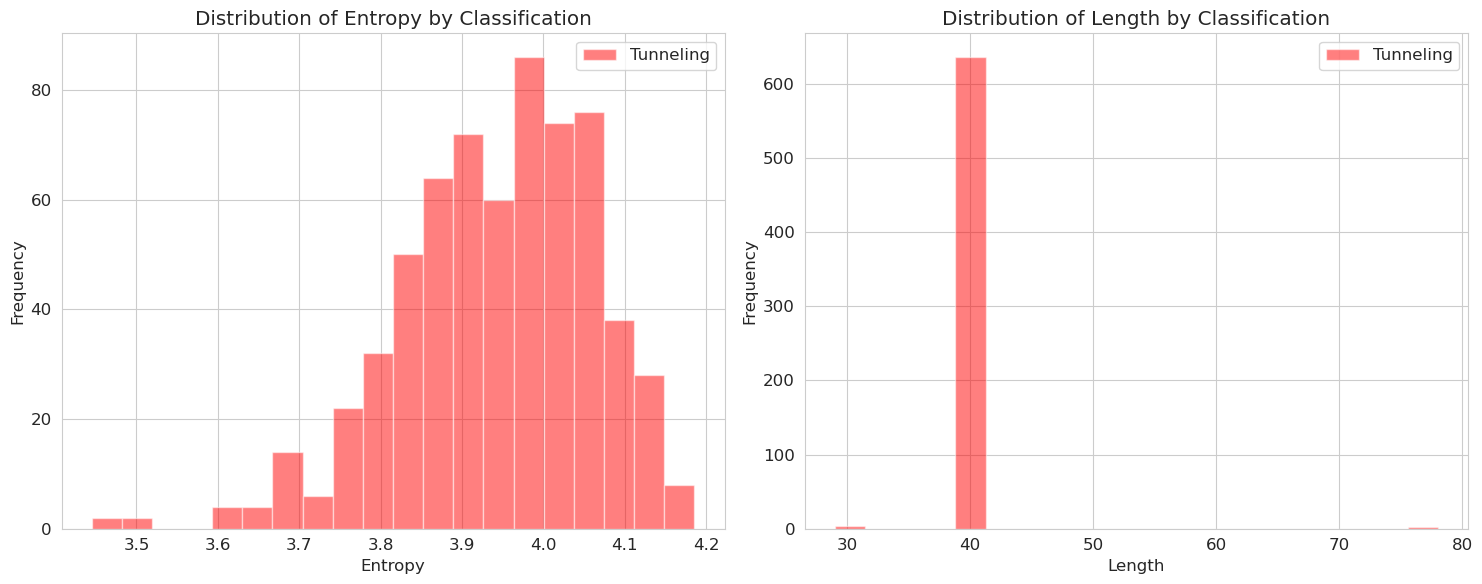

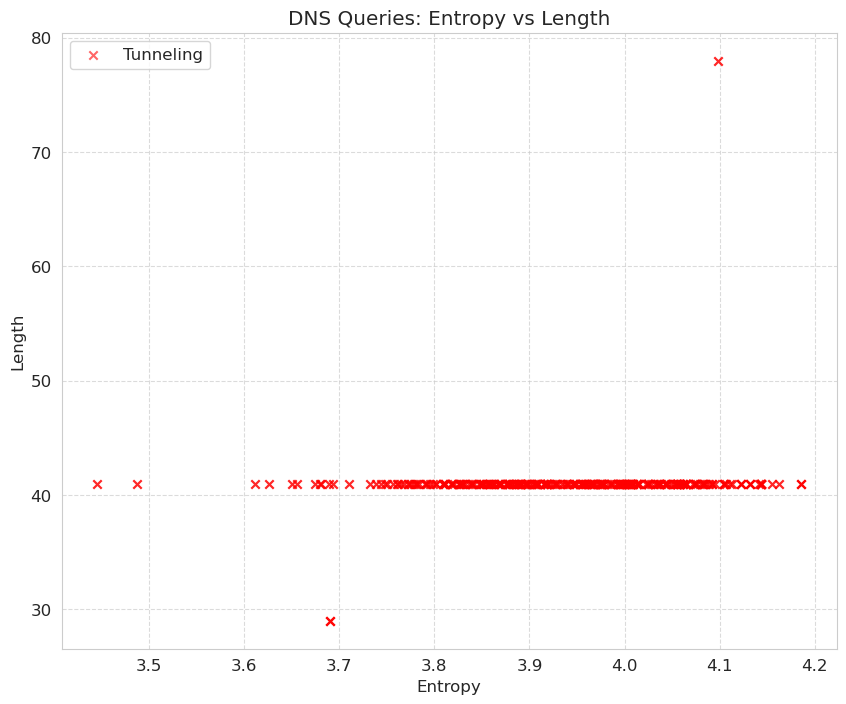

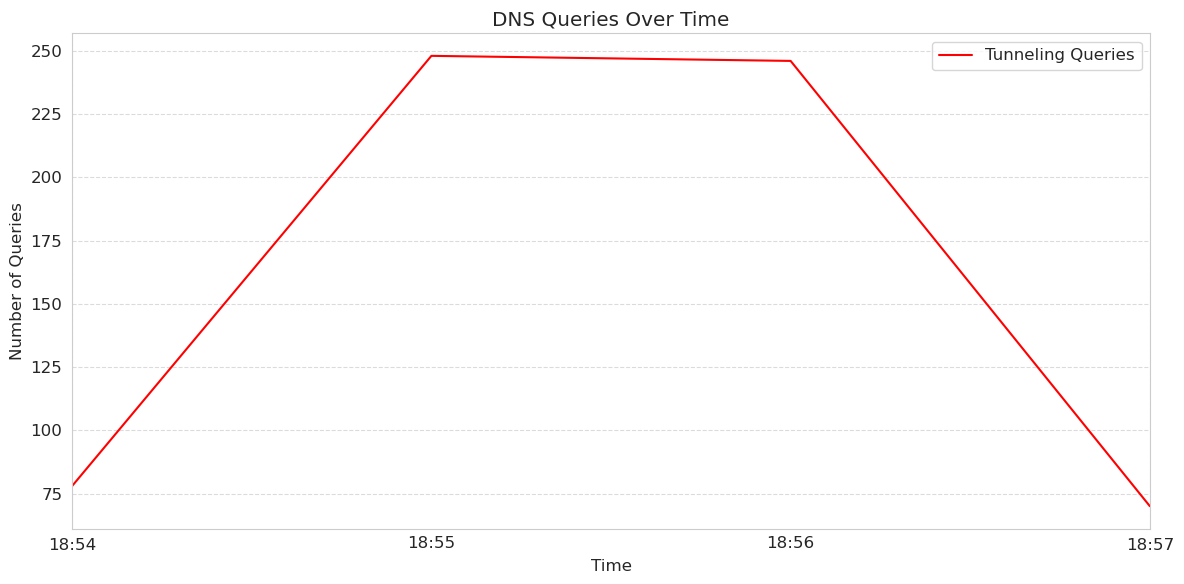


Results saved to 'dns_tunnel_detection_results.csv'

===== Analysis of Tunneling Domains =====

Entropy statistics for tunneling domains:
count    642.000000
mean       3.943047
std        0.119924
min        3.444911
25%        3.867465
50%        3.957940
75%        4.034024
max        4.185867
Name: entropy, dtype: float64

Length statistics for tunneling domains:
count    642.000000
mean      41.040498
std        2.273412
min       29.000000
25%       41.000000
50%       41.000000
75%       41.000000
max       78.000000
Name: length, dtype: float64

Common patterns in tunneling domain names:

Domain name prefix counts:
dnscat                638
connectivity-check      4
Name: count, dtype: int64

Found 638 domains using the dnscat tunneling tool

Sample of hex patterns used in dnscat tunneling:
- c4370165ebe083463b853b0109d0a2af03
- c4370165ebe083463b853b0109d0a2af03
- 4eae0100ece97c44cfd71600d532bd269d
- 4eae0100ece97c44cfd71600d532bd269d
- 80ef0165eb320f59ab0c6b010a22d5f4da


In [20]:
#  Test the model on real packet capture data
try:
    # Test the model on real packet capture data
    pcap_results = test_model_on_pcap_data('DNSTunnelingAttackPC.csv', loaded_model)
    
    if pcap_results is not None:
        # Save the results to a CSV file
        pcap_results.to_csv('dns_tunnel_detection_results.csv', index=False)
        print("\nResults saved to 'dns_tunnel_detection_results.csv'")
        
        # Analyze the characteristics of captured tunneling domains
        tunneling_domains = pcap_results[pcap_results['prediction'] == 1]
        if len(tunneling_domains) > 0:
            print("\n===== Analysis of Tunneling Domains =====")
            
            # Calculate statistics on entropy and length
            print(f"\nEntropy statistics for tunneling domains:")
            print(tunneling_domains['entropy'].describe())
            
            print(f"\nLength statistics for tunneling domains:")
            print(tunneling_domains['length'].describe())
            
            # Domain name pattern analysis
            print("\nCommon patterns in tunneling domain names:")
            
            # Extract parts of domain names for pattern analysis
            domain_parts = []
            domain_prefixes = []
            
            for domain in tunneling_domains['domain']:
                parts = domain.split('.')
                domain_parts.extend(parts)
                
                if len(parts) > 1:
                    domain_prefixes.append(parts[0])
            
            # Count frequency of domain prefixes
            prefix_counts = pd.Series(domain_prefixes).value_counts()
            print("\nDomain name prefix counts:")
            print(prefix_counts.head(5))
            
            # For dnscat specific analysis
            dnscat_domains = tunneling_domains[tunneling_domains['domain'].str.contains('dnscat')]
            if len(dnscat_domains) > 0:
                print(f"\nFound {len(dnscat_domains)} domains using the dnscat tunneling tool")
                
                # Analyze hex patterns in dnscat domains
                hex_patterns = []
                for domain in dnscat_domains['domain']:
                    parts = domain.split('.')
                    if len(parts) > 1 and len(parts[1]) > 5:  # Skip the 'dnscat' prefix
                        hex_patterns.append(parts[1])
                
                if hex_patterns:
                    print("\nSample of hex patterns used in dnscat tunneling:")
                    for pattern in hex_patterns[:5]:
                        print(f"- {pattern}")
except Exception as e:
    print(f"Error testing the model on packet capture data: {e}")
    import traceback
    traceback.print_exc()

In [21]:
#  Test real-time detection with example domains
# Create a real-time detection function
detect_tunneling = create_real_time_detection_function(loaded_model)

# Example of using the real-time detection function
print("\n========= Real-time Detection Example =========")
test_domains = [
    "google.com",
    "yahoo.com",
    "dnscat.4eae0100ece97c44cfd71600d532bd269d",
    "microsoft.com",
    "dnscat.c4370165ebe083463b853b0109d0a2af03"
]

print("\nTesting sample domains:")
for domain in test_domains:
    result = detect_tunneling(domain)
    status = "MALICIOUS" if result['is_tunneling'] else "benign"
    print(f"{domain:<50} : {status} (probability: {result['probability']:.4f}, entropy: {result['entropy']:.2f}, length: {result['length']})")

print("\n\nThe model is now ready to be used for DNS tunneling detection in real-time traffic.")
print("You can use the 'detect_tunneling()' function to check any domain.")


========= Real-time Detection Example =========

Testing sample domains:
google.com                                         : benign (probability: 0.0000, entropy: 2.65, length: 10)
yahoo.com                                          : benign (probability: 0.0000, entropy: 2.64, length: 9)
dnscat.4eae0100ece97c44cfd71600d532bd269d          : MALICIOUS (probability: 1.0000, entropy: 3.99, length: 41)
microsoft.com                                      : benign (probability: 0.0000, entropy: 3.03, length: 13)
dnscat.c4370165ebe083463b853b0109d0a2af03          : MALICIOUS (probability: 1.0000, entropy: 4.07, length: 41)


The model is now ready to be used for DNS tunneling detection in real-time traffic.
You can use the 'detect_tunneling()' function to check any domain.


In [22]:
# Add instructions for real-time monitoring integration
print("\n===== Integration with Real-Time Monitoring =====")
print("To use this detector with real-time DNS traffic in a VMware environment:")
print("1. Capture DNS traffic with a tool like tcpdump or Wireshark")
print("2. Export capture to CSV format")
print("3. Use the 'test_model_on_pcap_data()' function to analyze the traffic")
print("4. For real-time integration, consider:")
print("   - Setting up a packet capture daemon that exports to CSV periodically")
print("   - Processing new captures automatically with this script")
print("   - Generating alerts when tunneling is detected")


===== Integration with Real-Time Monitoring =====
To use this detector with real-time DNS traffic in a VMware environment:
1. Capture DNS traffic with a tool like tcpdump or Wireshark
2. Export capture to CSV format
3. Use the 'test_model_on_pcap_data()' function to analyze the traffic
4. For real-time integration, consider:
   - Setting up a packet capture daemon that exports to CSV periodically
   - Processing new captures automatically with this script
   - Generating alerts when tunneling is detected



========= Testing Model on DNSTunnelingAttackPC.csv =========
Loading packet capture data from DNSTunnelingAttackPC.csv...
Loaded 1212 packets from capture file.

Sample of packet capture data:
   No.                           Time           Source     Destination  \
0    1  2025-04-09 18:54:40.389337217  VMware_f1:4a:cd       Broadcast   
1    2  2025-04-09 18:54:40.392719469  VMware_f1:4a:cd       Broadcast   
2    3  2025-04-09 18:54:40.501758589      10.10.20.31  134.71.199.228   
3    4  2025-04-09 18:54:40.505713863   134.71.199.228     10.10.20.31   
4    5  2025-04-09 18:54:40.756587336      10.10.20.31  134.71.199.228   

  Protocol  Length                                               Info  
0      ARP      60             Who has 10.10.20.15? Tell 10.10.20.200  
1      ARP      60             Who has 10.10.20.15? Tell 10.10.20.200  
2      DNS     101  Standard query 0xd64a TXT dnscat.c4370165ebe08...  
3      DNS     148  Standard query response 0xd64a TXT dnscat.c437...  


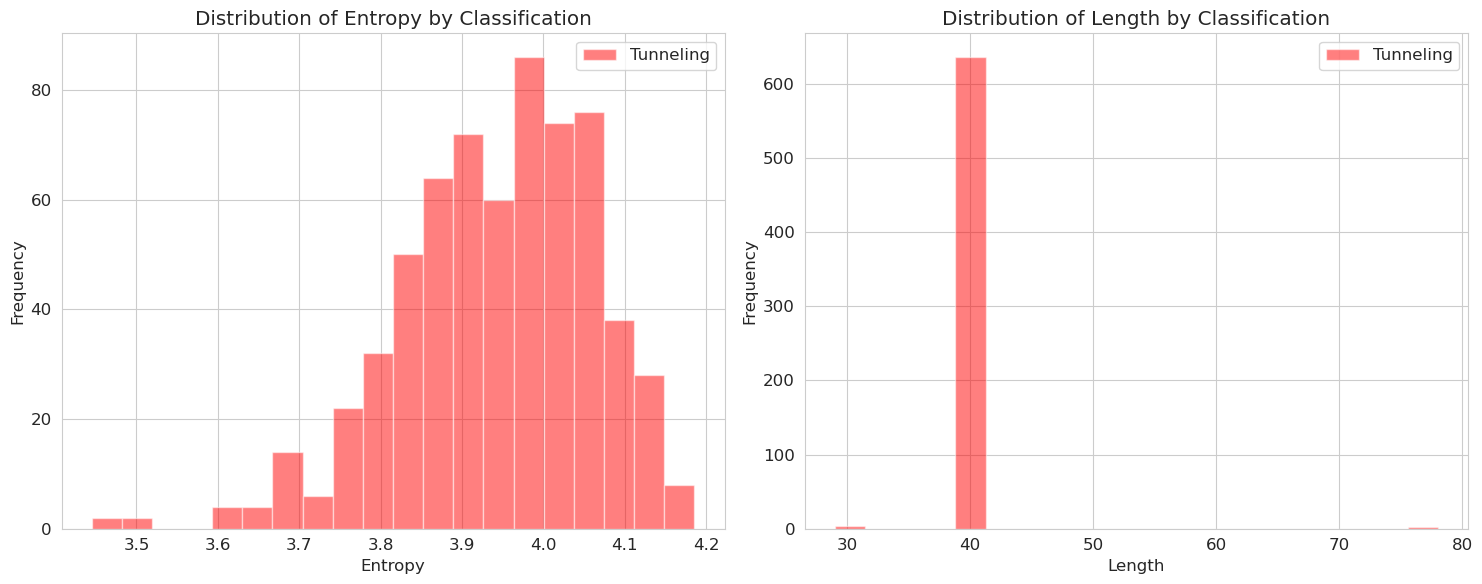

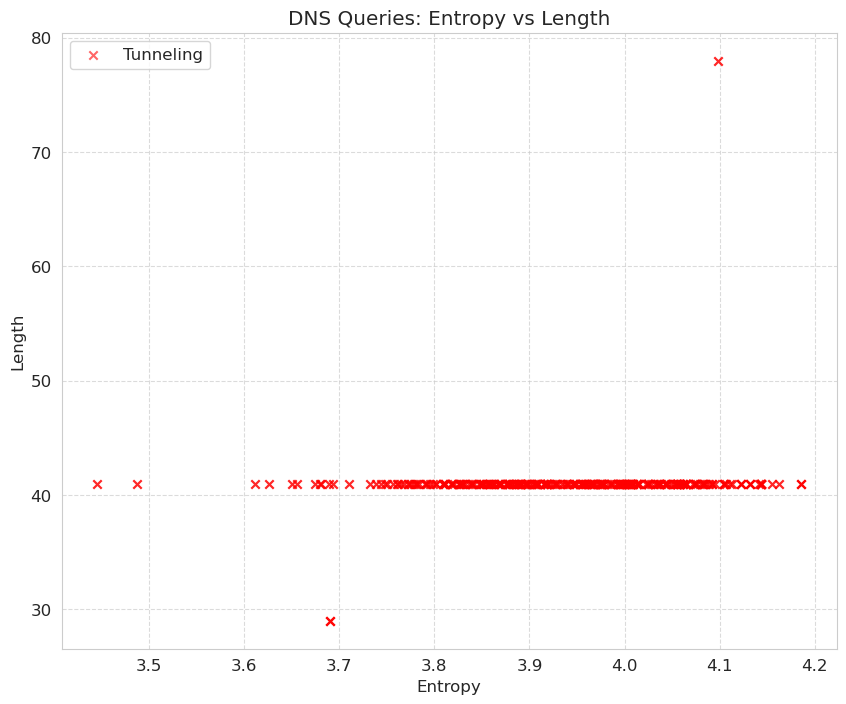

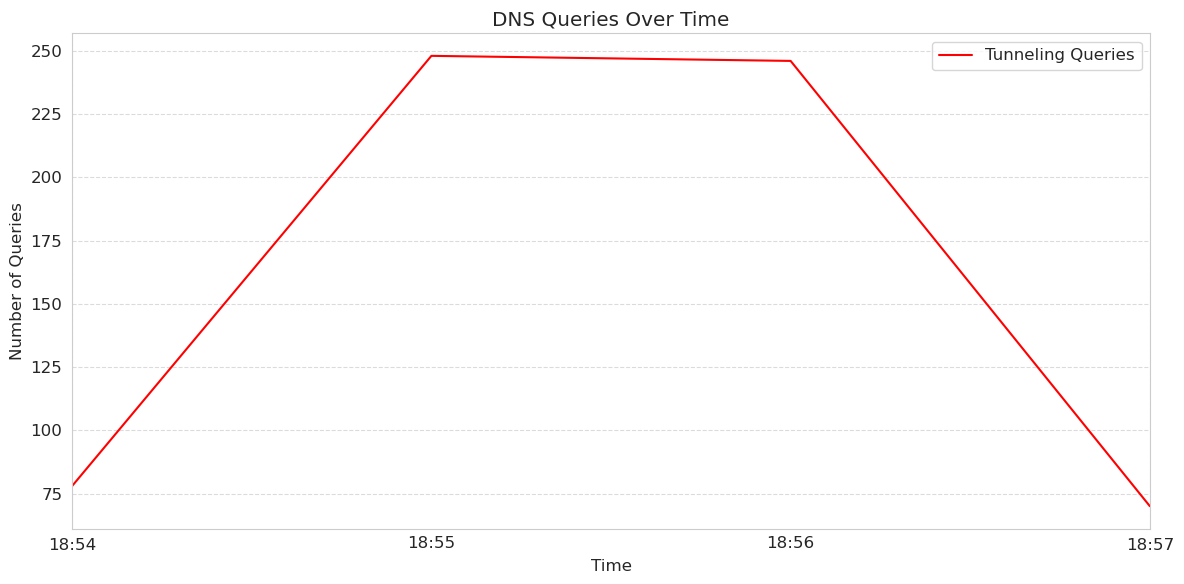


Results from DNSTunnelingAttackPC.csv saved to 'dns_attack_results.csv'

Unique domain analysis from DNSTunnelingAttackPC.csv:
                                           probability  prediction  count
domain                                                                   
dnscat.da860165eb918d38f616c7014e885e9d17          1.0         1.0      2
dnscat.db710100ec38b0c58dad5c012b73e75274          1.0         1.0      2
dnscat.dbd20165ebce75a8f402460172f1ecc126          1.0         1.0      2
dnscat.dc470165ebd1e3dba7f5fd015c8c69fb71          1.0         1.0      2
dnscat.dc6f0100ecf39c45c530cb011059d62f5e          1.0         1.0      2
dnscat.ddfd0165eb8b1bd5bc6d320112d9a35876          1.0         1.0      2
dnscat.de0e0165eb9aaf3c0d2c390194a2f8585b          1.0         1.0      2
dnscat.df5a0100ecd2a83c52f40900db9feb6e91          1.0         1.0      2
dnscat.d6090165eb96218a510c3f011e6f94d810          1.0         1.0      2
dnscat.d7260165eb420db9ece01b014a5509d2ac          1.0    

In [23]:
# Test specifically with DNSTunnelingAttackPC.csv and provide domain analysis
# Test the model specifically on the DNSTunnelingAttackPC.csv file
print("\n========= Testing Model on DNSTunnelingAttackPC.csv =========")
dns_attack_results = test_model_on_pcap_data('DNSTunnelingAttackPC.csv', loaded_model)

if dns_attack_results is not None:
    # Save the results
    dns_attack_results.to_csv('dns_attack_results.csv', index=False)
    print("\nResults from DNSTunnelingAttackPC.csv saved to 'dns_attack_results.csv'")
    
    # Count unique domains and their tunneling probabilities
    print("\nUnique domain analysis from DNSTunnelingAttackPC.csv:")
    domain_stats = dns_attack_results.groupby('domain').agg({
        'probability': 'mean',
        'prediction': 'mean',
        'domain': 'count'
    }).rename(columns={'domain': 'count'}).sort_values(by='probability', ascending=False)
    
    print(domain_stats.head(10))

In [24]:
#  Add command-line monitoring options
# Add option to run in live monitoring mode
print("\n===== Live Monitoring Option =====")
print("To monitor DNS traffic in real-time, run this script with:")
print("python dns_tunneling.py --monitor DNSTunnelingAttackPC.csv --interval 5 --output alerts.csv")

# Check if command line arguments were provided
import sys
if len(sys.argv) > 1 and sys.argv[1] == '--monitor':
    if len(sys.argv) > 2:
        monitor_file = sys.argv[2]
        interval = 5  # default interval
        output_file = None
        
        # Parse additional arguments
        if len(sys.argv) > 4 and sys.argv[3] == '--interval':
            try:
                interval = int(sys.argv[4])
            except:
                pass
                
        if len(sys.argv) > 6 and sys.argv[5] == '--output':
            output_file = sys.argv[6]
            
        # Start live monitoring
        process_live_traffic(monitor_file, interval, output_file)


===== Live Monitoring Option =====
To monitor DNS traffic in real-time, run this script with:
python dns_tunneling.py --monitor DNSTunnelingAttackPC.csv --interval 5 --output alerts.csv
